# Figure 6a-e: Encoding models for retinal ganglion cell recordings

In [1]:
import h5py
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os

from neuropacks import RET1
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
%matplotlib inline

In [2]:
data_path = os.path.join(os.environ['HOME'], 'fits/uoineuro/tuning/ret1')

In [3]:
example_retina = '20080628_R4'
example_recording = 'cell2_recording0'

## Figure 6a: Example fitted STRFs from retina

In [4]:
# read in example retinal STRF
ret1_path = os.path.join(data_path, example_retina + '.h5')
results = h5py.File(ret1_path, 'r')

In [5]:
# get h5 dataset for example recording
cell_recording = results[example_recording]

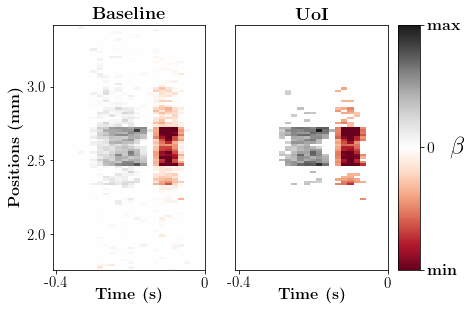

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(6, 4.5))

baseline_strf = np.flip(cell_recording['lasso/strfs'][:].T,
                     axis=(0, 1))
uoi_strf = np.flip(cell_recording['uoi_lasso_bic/strfs'][:].T,
                   axis=(0, 1))

# plot baseline and uoi strfs
axes[0].imshow(
    baseline_strf,
    cmap=plt.get_cmap('RdGy'),
    vmin=-1e-06, vmax=1e-06)
img = axes[1].imshow(
    uoi_strf,
    cmap=plt.get_cmap('RdGy'),
    vmin=-1e-06, vmax=1e-06)

# create colorbar
ax_bottom_right_x, ax_bottom_right_y = \
    fig.transFigure.inverted().transform(axes[1].transAxes.transform([1.0, 0.]))
ax_top_right_x, ax_top_right_y = \
    fig.transFigure.inverted().transform(axes[1].transAxes.transform([1.0, 1.0]))
cax = fig.add_axes([ax_bottom_right_x + 0.025,
                    ax_bottom_right_y,
                    0.05,
                    ax_top_right_y - ax_bottom_right_y])
cb = fig.colorbar(img, cax)
cb.set_ticks([-1e-06, 0, 1e-06])
cb.set_ticklabels([r'\textbf{min}', 0, r'\textbf{max}'])
cb.ax.set_ylabel(r'$\beta$',
                 rotation=0,
                 labelpad=-10,
                 horizontalalignment='left',
                 verticalalignment='center')
cb.ax.tick_params(labelsize=16)

# titles
axes[0].set_title(r'\textbf{Baseline}', fontsize=18)
axes[1].set_title(r'\textbf{UoI}', fontsize=18)
axes[0].set_ylabel(r'\textbf{Positions (mm)}', fontsize=16)

# set y ticks
axes[0].set_yticks([320 * (5.312 - 3) / (5.312 - 0.0083),
                    320 * (5.312 - 2.5) / (5.312 - 0.0083),
                    320 * (5.312 - 2) / (5.312 - 0.0083)])
axes[0].set_yticklabels([2.0, 2.5, 3.0])
axes[1].set_yticks([])

# stylistic plot changes
for ax in axes:
    ax.set_aspect('auto')
    ax.set_xticks([0, 24])
    ax.set_xticklabels(['-0.4', '0'])
    ax.set_ylim([125, 225])
    ax.tick_params(labelsize=15)
    ax.set_xlabel(r'\textbf{Time (s)}', fontsize=16, labelpad=-3)
    
plt.savefig('example_ret_strf.pdf', bbox_inches='tight')

In [7]:
results.close()

## Figure 6b-e: Comparison of STRF performances and coefficients

In [8]:
retinas = {
    '20080516_R1': ['cell0_recording0',
                    'cell0_recording2',
                    'cell2_recording0',
                    'cell3_recording0',
                    'cell4_recording0',
                    'cell5_recording0'],
    '20080628_R4': ['cell0_recording0',
                    'cell2_recording0',
                    'cell3_recording0',
                    'cell5_recording0',
                    'cell6_recording0',
                    'cell7_recording0',
                    'cell9_recording0',
                    'cell12_recording0',
                    'cell13_recording0'],
    '20080628_R6': ['cell1_recording0',
                    'cell2_recording0',
                    'cell4_recording0',
                    'cell5_recording0',
                    'cell6_recording0',
                    'cell7_recording0',
                    'cell8_recording0',
                    'cell10_recording0']
}

In [9]:
baseline_srs = []
uoi_srs = []
baseline_r2s = []
uoi_r2s = []
baseline_bics = []
uoi_bics = []
baseline_coefs = []
uoi_coefs = []

# iterate over retina files
for retina, recordings in retinas.items():
    results = h5py.File(os.path.join(data_path, retina + '.h5'), 'r')
    # iterate over recordings
    for cell_recording in recordings:
        # calculate selection ratios
        baseline_strf = results[cell_recording]['lasso/strfs'][:]
        baseline_srs.append(np.count_nonzero(baseline_strf) / baseline_strf.size)
        uoi_strf = results[cell_recording]['uoi_lasso_bic/strfs'][:]
        uoi_srs.append(np.count_nonzero(uoi_strf) / uoi_strf.size)
        
        # coefficients normalized to maximum
        max_coef = np.max([np.abs(baseline_strf.ravel()), np.abs(uoi_strf.ravel())])
        baseline_coefs.append(baseline_strf.ravel() / max_coef)
        uoi_coefs.append(uoi_strf.ravel() / max_coef)
        # get inset coefs
        if retina == example_retina and cell_recording == example_recording:
            inset_baseline_coef = baseline_coefs[-1]
            inset_uoi_coef = uoi_coefs[-1]

        # extract predictive performance
        baseline_r2s.append(results[cell_recording]['lasso/r2s_test'][:].max())
        uoi_r2s.append(results[cell_recording]['uoi_lasso_bic/r2s_test'][:].max())

        # extract model parsimony
        baseline_bics.append(results[cell_recording]['lasso/bics'][:].min())
        uoi_bics.append(results[cell_recording]['uoi_lasso_bic/bics'][:].min())

    results.close()

In [10]:
baseline_srs = np.array(baseline_srs)
uoi_srs = np.array(uoi_srs)
baseline_r2s = np.array(baseline_r2s)
uoi_r2s = np.array(uoi_r2s)
baseline_bics = np.array(baseline_bics)
uoi_bics = np.array(uoi_bics)
baseline_coefs = np.concatenate(baseline_coefs)
uoi_coefs = np.concatenate(uoi_coefs)

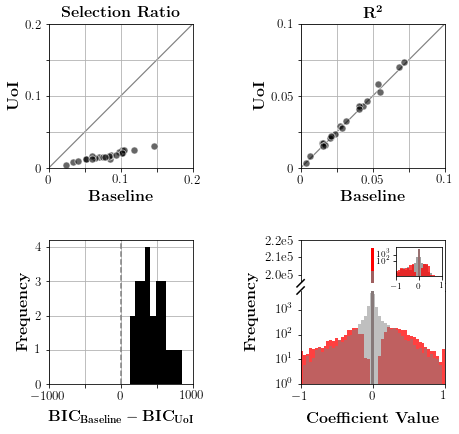

In [12]:
# figure and subplot dimensions
figsize = 6 # inches
subplotsize = 2 # inches
v_spacing = 1. # inches
h_spacing = 1.5

# create figure and subplots
fig = plt.figure(figsize=(6, 6))
# selection ratios
srs = fig.add_axes([0, (subplotsize + v_spacing) / figsize,
                    subplotsize / figsize, subplotsize / figsize])
# predictive performance
pp = fig.add_axes([(subplotsize + h_spacing) / figsize, (subplotsize + v_spacing) / figsize,
                   subplotsize / figsize, subplotsize / figsize])
# bayesian information criterion
bics = fig.add_axes([0, 0,
                     subplotsize / figsize, subplotsize / figsize])

# split plot requires three separate axes
lower_size = 1.30 # inches
gap_spacing = 0.1 # inches
upper_size = subplotsize - lower_size - gap_spacing
coefs_lower = fig.add_axes([(subplotsize + h_spacing) / figsize, 0,
                            subplotsize / figsize, lower_size / figsize])
coefs_upper = fig.add_axes([(subplotsize + h_spacing) / figsize,  (lower_size + gap_spacing) / figsize,
                            subplotsize / figsize, upper_size / figsize])
in_between = fig.add_axes([(subplotsize + h_spacing) / figsize, lower_size / figsize,
                           subplotsize / figsize, gap_spacing / figsize])
# selection ratios
srs.scatter(
    baseline_srs, uoi_srs,
    s=50,
    alpha=0.6,
    color='k',
    edgecolor='white')
# stylize selection ratio plot
srs.set_xlim([0, 0.2])
srs.set_xticks([0, 0.05,  0.10, 0.15, 0.20])
srs.set_xticklabels(['0', '', '0.1', '', '0.2'])

# plot r2 values
pp.scatter(baseline_r2s, uoi_r2s,
                s=50,
                alpha=0.6,
                color='k',
                edgecolor='white')
pp.set_xlim([0, 0.1])
pp.set_xticks([0, 0.025, 0.05, 0.075, 0.1])
pp.set_xticklabels(['0', '', '0.05', '', '0.1'])

# top row: make scatter plots uniform
for ax in [srs, pp]:
    ax.set_ylim(ax.get_xlim())
    ax.set_yticks(ax.get_xticks())
    ax.set_yticklabels(ax.get_xticklabels())
    ax.plot(
        ax.get_xlim(), ax.get_ylim(),
        color='gray',
        linewidth=1.2,
        zorder=-1)

# histogram of BIC difference distributions
bics.hist(np.array(baseline_bics) - np.array(uoi_bics),
             color='black')
bics.set_xlim([-1000, 1000])
bics.set_xticks([-1000, -500, 0, 500, 1000])
bics.set_xticklabels(['$-1000$', '', 0, '', '$1000$'])
bics.axvline(0, color='gray', linestyle='--')

# plot coefficient distribution
bins = np.linspace(-1, 1, 51)
coefs_lower.hist(uoi_coefs[uoi_coefs != 0],
                 bins=bins,
                 alpha=0.75,
                 color='red')
coefs_lower.hist(baseline_coefs[baseline_coefs != 0],
                 bins=bins,
                 alpha=0.5,
                 color='gray')
coefs_lower.bar(x=0,
                height=6000,
                width=0.05,
                color='red')
coefs_lower.bar(x=0,
                height=6000,
                width=0.05,
                alpha=0.95,
                color='gray')
coefs_lower.set_yscale('log', nonposy='clip')
coefs_lower.set_xlim([-1, 1])
coefs_lower.set_yscale('log')
coefs_lower.set_ylim([1, 6000])
coefs_lower.set_yticks([1, 10, 100, 1000])
coefs_lower.spines['top'].set_visible(False)
# split graph - upper portion
lower_y = 1.95e5
upper_y = 2.2e5
n_zero_baseline = baseline_coefs[baseline_coefs == 0].size 
n_zero_uoi = uoi_coefs[uoi_coefs == 0].size
coefs_upper.bar(x=0,
        height=(n_zero_uoi - lower_y) / (upper_y - lower_y),
        width=0.05,
        color='red')
coefs_upper.bar(x=0,
        height=(n_zero_baseline - lower_y) / (upper_y - lower_y),
        width=0.05,
        alpha=0.75,
        color='gray')
coefs_upper.set_xlim(coefs_lower.get_xlim())
coefs_upper.set_xticks([])
coefs_upper.set_ylim([0, 1])
coefs_upper.set_yticks([(2e5 - lower_y) / (upper_y - lower_y),
                        (2.1e5 - lower_y) / (upper_y - lower_y),
                        (2.2e5 - lower_y) / (upper_y - lower_y)])
coefs_upper.set_yticklabels(['2.0e5', '2.1e5', '2.2e5'])
coefs_upper.spines['bottom'].set_visible(False)

# make diagonal lines for split bar
d = .5  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=in_between.transAxes, color='k', clip_on=False)
in_between.set_xlim([0, 1])
in_between.set_ylim([0, 1])
# handle aspect ratio to make lines diagonal
ratio = subplotsize / gap_spacing
in_between.plot((-d / ratio, d / ratio), (-d, d), **kwargs)        # top-left diagonal
in_between.plot((-d / ratio, d / ratio), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
in_between.spines['top'].set_visible(False)
in_between.spines['left'].set_visible(False)
in_between.spines['bottom'].set_visible(False)
in_between.spines['right'].set_visible(True)
in_between.set_xticks([])
in_between.set_yticks([])

# add inset to coefficient plot
inset_size = subplotsize / 5
inset_bins = np.linspace(-1, 1, 21)
inset = fig.add_axes([(1.66 * subplotsize + h_spacing) / figsize, 0.75 * subplotsize / figsize,
                      1.6 * inset_size / figsize, inset_size / figsize])
inset.hist(inset_baseline_coef[inset_baseline_coef != 0],
           bins=inset_bins,
           alpha=0.75,
           color='gray')
inset.hist(inset_uoi_coef[inset_uoi_coef != 0],
           bins=inset_bins,
           alpha=0.75,
           color='red')
inset.bar(x=0,
          height=inset_uoi_coef[inset_uoi_coef == 0].size,
          width=0.1,
          alpha=0.80,
          color='red')
inset.bar(x=0,
          height=inset_baseline_coef[inset_baseline_coef == 0].size,
          width=0.1,
          alpha=0.80,
          color='gray')
inset.set_yscale('log', nonposy='clip')
inset.set_xlim([-1, 1])
inset.set_yticks([100, 1000])
inset.tick_params(labelsize=9)

# stylize plots
for ax in [srs, pp, bics]:
    ax.grid('on')
    ax.set_axisbelow(True)
    
for ax in [srs, pp, bics, coefs_lower, coefs_upper]:
    ax.tick_params(labelsize=13)

# labels
srs.set_xlabel(r'\textbf{Baseline}', fontsize=16)
srs.set_ylabel(r'\textbf{UoI}', fontsize=16)
pp.set_xlabel(r'\textbf{Baseline}', fontsize=16)
pp.set_ylabel(r'\textbf{UoI}', fontsize=16)
bics.set_xlabel(
    r'$\textbf{BIC}_{\normalsize\textbf{Baseline}} - \textbf{BIC}_{\normalsize\textbf{UoI}}$',
    fontsize=16,
    labelpad=10)
bics.set_ylabel(
    r'\textbf{Frequency}',
    fontsize=16)
coefs_lower.set_xlabel(
    r'\textbf{Coefficient Value}',
    labelpad=10,
    fontsize=16)
fig.text(
    x=(subplotsize + 0.55 * h_spacing) / figsize,
    y=0.5 * subplotsize / figsize,
    s=r'\textbf{Frequency}',
    horizontalalignment='center',
    verticalalignment='center',
    rotation=90,
    fontsize=16)

# titles
srs.set_title(r'\textbf{Selection Ratio}', fontsize=16)
pp.set_title(r'$\mathbf{R^2}$', fontsize=16)

plt.savefig('ret1_tuning_metrics.pdf', bbox_inches='tight')